# Отток клиентов телекоммуникационной компании 

## Описание проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Предоставлены персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание данных 

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре:

    + begin_date - дата заключения договора
    + end_date - дата расторжения договора
    + type - тип договора
    + paperless_billing - получение электронного чека
    + payment_method - способ оплаты
    + monthly_charges - ежемесячные платежи
    + total_charges - суммарные платежи
    
    
- `personal.csv` — персональные данные клиента:

    + gender - пол клиента
    + senior_citizen - является ли клиент пенсионером
    + partner - наличие супруга
    + dependents - наличие детей
    
    
- `internet.csv` — информация об интернет-услугах:

    + internet_service - тип подключения интернета
    + online_security - блокировка небезопасных сайтов
    + online_backup - облачное хранилище файлов для резервного копирования данных
    + device_protection - антивирус
    + tech_support - выделенная линия технической поддержки
    + streaming_tv - стриминговое телевидение
    + streaming_movies - каталог фильмов
    
    
- `phone.csv` — информация об услугах телефонии:

    + multiple_lines - подключение телефона к нескольким линиям


Во всех файлах столбец `customer_id` содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.

## 0. Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from scipy import stats as st

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## 1. Подготовка данных

##### Загрузка данных

In [3]:
contract = pd.read_csv('/datasets/contract.csv')
internet = pd.read_csv('/datasets/internet.csv')
personal = pd.read_csv('/datasets/personal.csv')
phone = pd.read_csv('/datasets/phone.csv')

In [4]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
                    'payment_method', 'monthly_charges', 'total_charges']
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
                    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [7]:
phone.columns = ['customer_id', 'multiple_lines']
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


+ Привёл названия столбцов к единому стилю
+ Имеют место быть некорректные типы данных в столбцах

##### Проверка на дубликаты

In [8]:
contract.duplicated().sum()

0

Дубликаты отсутствуют

##### Выделение целевого признака

In [9]:
contract['exited'] = (contract['end_date'] != 'No').astype('int')

##### Изменение типов данных

+ Столбцы с датами приведём к типу *datetime*
+ В столбце *total_charges* у клиентов, заключивших договор 2 февраля 2020 года (дата на которую актуальны данные), стоят пробелы, заменим их на ноль и привёдем данные к числовому типу.

In [10]:
contract.loc[contract['end_date'] == 'No', 'end_date'] = '2020-02-01'

contract.loc[contract['total_charges'] == ' ', 'total_charges'] = 0
contract['total_charges'] = pd.to_numeric(contract['total_charges'])

contract['begin_date'] = pd.to_datetime(contract['begin_date'])
contract['end_date'] = pd.to_datetime(contract['end_date'])

##### Расчёт длительности действия договоров

In [11]:
contract['lifetime'] = contract['end_date'] - contract['begin_date']
contract['lifetime'] = contract['lifetime'].dt.days
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,lifetime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


##### Объединение таблиц

In [12]:
data = contract.merge(personal, how='left', on=['customer_id'])
data = data.merge(internet, how='left', on=['customer_id'])
data = data.merge(phone, how='left', on=['customer_id'])

In [13]:
pd.set_option('display.max_columns', 50)
data.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,lifetime,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


##### One-hot-encoding

В данных много категориальных признаков, для их обработки применим методику OHE.\
При объединении таблиц, в некоторых столбцах появились отсутствующие значения. Однако эти пропуски несут в себе информацию о том какими услугами не пользуется клиент, поэтому важно их сохранить и выделить в отдельную категорию.

In [14]:
with_nan = ['internet_service', 'online_security', 'online_backup', 'device_protection',
            'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

for column in with_nan:
    data.loc[data[column].isna() == True, column] = 'None'

In [15]:
data_ohe = data.copy()

cat_features = ['type', 'paperless_billing', 'payment_method',
                'gender', 'partner', 'dependents',
                'internet_service', 'online_security', 'online_backup',
                'device_protection', 'tech_support', 'streaming_tv',
                'streaming_movies', 'multiple_lines']

data_ohe = pd.get_dummies(data_ohe, drop_first=True, columns=cat_features)

##### Устранение лишних столбцов

+ *monthly_charges* - после проведения исследовательского анализа стало ясно, что ушедших клиентов нельзя объединить в более-менее однородную группу по размеру ежемесячного платежа (это раз). В нашем распоряжении нет данных о поведении клиентов, лишь некоторые демографические показатели и список услуг, которые на них оформлены (это два). Таким образом мы ищем категорию клиентов, скажем так проблемную, и принадлежит ли ей клиент можно понять сразу как он зашёл в офис подписывать договор (в жизни конечно не так, но в нашей учебной задаче выходит так). И нам совершенно не важно, сколько клиент тратит ежемесячно на услуги и сколько денег всего заплатит нашей компании.
+ *total_charges* - для нашей задачи не несёт полезной информации. Сильно коррелирует с длительностью обслуживания. Жизненный цикл среди ушедших клиентов разный, как большой, так и маленький встречается, поэтому этот признак внесёт лишь сумятицу в модель.
+ *customer_id* - не несёт полезной информации.
+ *end_date* - приведёт к утечке целевого признака.
+ *begin_date* - на самом деле не знаю, но интуиция подсказывает, что это бесполезный признак.

In [16]:
data_ohe.drop(['monthly_charges', 'total_charges', 'customer_id',
               'begin_date', 'end_date'],
                axis=1, inplace=True)

In [17]:
data_ohe.head()

,exited,lifetime,senior_citizen,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_None,online_security_None,online_security_Yes,online_backup_None,online_backup_Yes,device_protection_None,device_protection_Yes,tech_support_None,tech_support_Yes,streaming_tv_None,streaming_tv_Yes,streaming_movies_None,streaming_movies_Yes,multiple_lines_None,multiple_lines_Yes
0,0,31,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0,1036,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,1,61,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,0,1371,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
4,1,61,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Разделение на выборки

In [18]:
target_ohe = data_ohe['exited']
features_ohe = data_ohe.drop(['exited'], axis=1)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=.25, random_state=42)

### Дополнительный датасет

Датасет сформирован после анализа и обучения моделей на первом датасете.
+ Убраны признаки отвечающие за дополнительные интернет-услуги, как маловажные
+ Сгенерированы новые признаки:
    + *family* - является ли клиент семейным или нет (если клиент имеет супруга или детей, то считается семейным)
    + *internet_service* - пользуется клиент интернетом или нет
    + *phone_service* - пользуется клиент телефоном или нет

In [19]:
alt_data = data.copy()
alt_data['phone_service'] = alt_data['multiple_lines']

columns1 = ['internet_service', 'phone_service']
columns2 = ['partner', 'dependents']

for column in columns1:
    alt_data.loc[alt_data[column] == 'None', column] = 0
    alt_data.loc[alt_data[column] != 'None', column] = 1

for column in columns2:
    alt_data.loc[alt_data[column] == 'No', column] = 0
    alt_data.loc[alt_data[column] == 'Yes', column] = 1

alt_data['family'] = alt_data['partner'] * alt_data['dependents']

alt_data.drop(['multiple_lines', 'partner', 'dependents',
               'total_charges', 'customer_id',
               'begin_date', 'end_date', 'monthly_charges',
               'online_security', 'online_backup',
               'device_protection', 'tech_support',
               'streaming_tv', 'streaming_movies'],
                axis=1, inplace=True)

In [20]:
alt_cat_features = ['type', 'paperless_billing',
                    'payment_method', 'gender']

alt_data_ohe = pd.get_dummies(alt_data, drop_first=True, columns=alt_cat_features)

In [21]:
alt_target_ohe = alt_data_ohe['exited']
alt_features_ohe = alt_data_ohe.drop(['exited'], axis=1)

alt_features_train_ohe, alt_features_test_ohe, alt_target_train_ohe, alt_target_test_ohe = train_test_split(
    alt_features_ohe, alt_target_ohe, test_size=.25, random_state=42)

## 2. Исследовательский анализ данных 

Нам предоставлены данные по 7043 клиентам, из них:
   + 4835 - пользуется и интернетом и телефонией
   + 1526 - пользуется только телефонией
   + 682 - пользуется только интернетом
    
1869 клиентов прекратили обслуживание (26,5%).

##### Распределение типов заключаемых договоров

In [22]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Клиентов с годовыми контрактами в 1.22 раза меньше, чем с контрактами с ежемесячным списанием.

##### Распределение размеров ежемесячных платежей

In [23]:
def compare_plot(data1, data2):
    data1.hist(bins=50, density=True, alpha=0.6, label='Оставшиеся', range=(data1.min(), data1.max()))
    data2.hist(bins=50, density=True, alpha=0.6, label='Ушедшие', range=(data1.min(), data1.max()))
    plt.title('Распределение клиентов по размеру ежемесячных платежей')
    plt.xlabel('Размер ежемесячного платежа')
    plt.ylabel('Доля клиентов')
    plt.legend(loc='upper right')
    plt.show()
    print('Оставшиеся клиенты:')
    print(data1.describe())
    print()
    print('Ушедшие клиенты:')
    print(data2.describe())

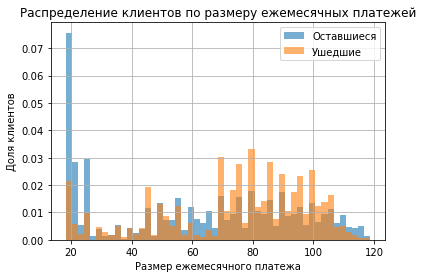

Оставшиеся клиенты:
count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: monthly_charges, dtype: float64

Ушедшие клиенты:
count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: monthly_charges, dtype: float64


In [24]:
compare_plot(contract[contract['exited'] == 0]['monthly_charges'],
             contract[contract['exited'] == 1]['monthly_charges'])

+ Распределение по ежемесячным платежам схоже в обеих группах.
+ Ушедшие клиенты в среднем платили бо́льшие суммы.
+ Доля клиентов с минимальными платежами среди ушедших значительно меньше, нежели среди оставшихся.

##### Проверка гипотезы о различии средних размеров ежемесячных платежей

$H_0$ - средний размер ежемесячных платежей не отличается среди оставшихся и ушедших клиентов\
$H_1$ - средний размер ежемесячных платежей различается

In [25]:
print('Средний размер ежемесячных платежей оставшихся клиентов: {:.2f} денег'
      .format(contract[contract['exited'] == 0]['monthly_charges'].mean()))
print('Средний размер ежемесячных платежей ушедших клиентов: {:.2f} денег'
      .format(contract[contract['exited'] == 1]['monthly_charges'].mean()))
print()
alpha = .05
results = st.ttest_ind(
    contract[contract['exited'] == 0]['monthly_charges'],
    contract[contract['exited'] == 1]['monthly_charges'],
    equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний размер ежемесячных платежей оставшихся клиентов: 61.27 денег
Средний размер ежемесячных платежей ушедших клиентов: 74.44 денег

p-значение: 8.592449331547538e-73
Отвергаем нулевую гипотезу


Средний размер ежемесячных платежей в разных группах статистически различается.

##### Использование услуг

Распределение среди ушедших клиентов:
   + интернет + телефония: 85%
   + только интернет: 9%
   + только телефония: 6%
   
Распределение среди оставшихся клиентов:
   + интернет + телефония: 63%
   + только интернет: 10%
   + только телефония: 27%

##### Использование интернета

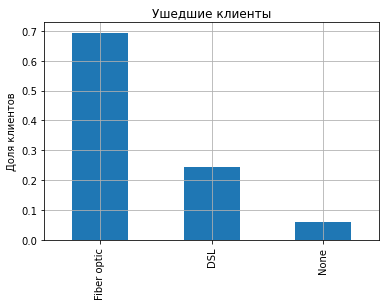

Fiber optic    0.693954
DSL            0.245586
None           0.060460
Name: internet_service, dtype: float64

In [26]:
data[data['exited'] == 1]['internet_service'].value_counts(normalize=True).plot(kind='bar', grid=True)
plt.title('Ушедшие клиенты')
plt.ylabel('Доля клиентов')
plt.show()

data[data['exited'] == 1]['internet_service'].value_counts(normalize=True)

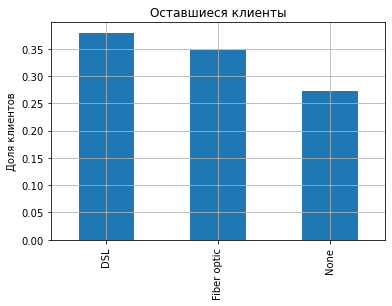

DSL            0.379204
Fiber optic    0.347700
None           0.273096
Name: internet_service, dtype: float64

In [27]:
data[data['exited'] == 0]['internet_service'].value_counts(normalize=True).plot(kind='bar', grid=True)
plt.title('Оставшиеся клиенты')
plt.ylabel('Доля клиентов')
plt.show()

data[data['exited'] == 0]['internet_service'].value_counts(normalize=True)

+ 94% ушедших клиентов пользовались интернетом
+ Ушедшие клиенты намного чаще пользовались оптоволоконным интернетом, нежели оставшиеся клиенты
+ Складывается впечатление, что в компании какие-то проблемы оптоволоконным интернетом

##### Использование телефона

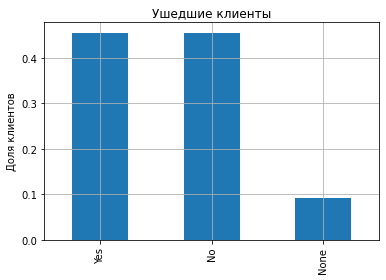

Yes     0.454789
No      0.454254
None    0.090958
Name: multiple_lines, dtype: float64

In [28]:
data[data['exited'] == 1]['multiple_lines'].value_counts(normalize=True).plot(kind='bar', grid=True)
plt.title('Ушедшие клиенты')
plt.ylabel('Доля клиентов')
plt.show()

data[data['exited'] == 1]['multiple_lines'].value_counts(normalize=True)

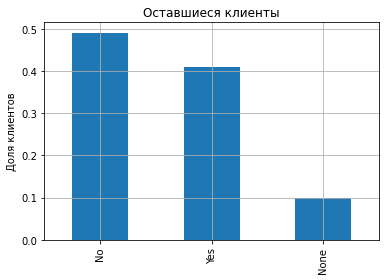

No      0.491109
Yes     0.409934
None    0.098956
Name: multiple_lines, dtype: float64

In [29]:
data[data['exited'] == 0]['multiple_lines'].value_counts(normalize=True).plot(kind='bar', grid=True)
plt.title('Оставшиеся клиенты')
plt.ylabel('Доля клиентов')
plt.show()

data[data['exited'] == 0]['multiple_lines'].value_counts(normalize=True)

+ Распределения драматически не различаются

##### Распределение количества ушедших клиентов относительно времени обслуживания

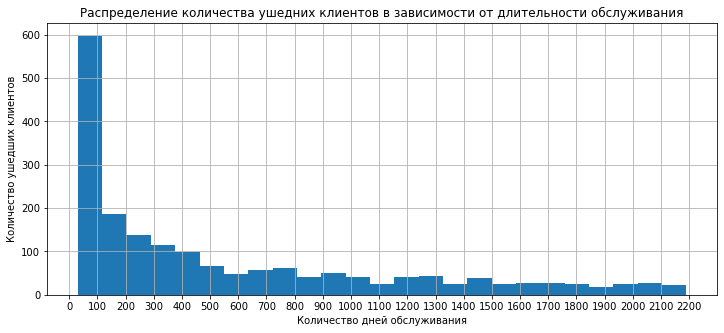

In [30]:
contract[contract['exited'] == 1]['lifetime'].plot(kind='hist', bins=25, grid=True,
                       xticks = [x * 100 for x in range(23)],
                       figsize = [12, 5],
                       title='Распределение количества ушедних клиентов в зависимости от длительности обслуживания')

plt.xlabel('Количество дней обслуживания');
plt.ylabel('Количество ушедших клиентов');

In [31]:
median_days = contract[contract['exited'] == 1]['lifetime'].median()
print('Медианное количество дней ослуживания среди ушедших клиентов', median_days)

Медианное количество дней ослуживания среди ушедших клиентов 304.0


+ Большинство клиентов уходит в первые 3 месяца обслуживания
+ Половина клиентов уходит в первые 10 месяцев обслуживания

# 3. Обучение моделей

In [32]:
def print_metrics(model, features_data, target_data):
    predicted_data = model.predict(features_data)
    probabilities = model.predict_proba(features_data)
    probabilities_one = probabilities[:, 1]

    fpr, tpr, thresholds = roc_curve(target_data, probabilities_one)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid(True)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    
    accuracy = model.score(features_data, target_data)
    precision = precision_score(target_data, predicted_data)
    recall = recall_score(target_data, predicted_data)
    f1 = f1_score(target_data, predicted_data)
    auc_roc = roc_auc_score(target_data, probabilities_one)
    
    print('Accuracy = {:.3f}'.format(accuracy))
    print('Precision = {:.3f}'.format(precision))
    print('Recall = {:.3f}'.format(recall))
    print('F1-мера = {:.3f}'.format(f1))
    print('AUC-ROC = {:.3f}'.format(auc_roc))
    
    return auc_roc, accuracy

In [33]:
columns = ['AUC-ROC', 'Accuracy', 'Время обучения']
index = ['Логистическая регрессия', 'Случайный лес', 'CatBoost',
         'Логистическая регрессия (alternative dataset)',
         'Случайный лес (alternative dataset)',
         'CatBoost (alternative dataset)']
results = pd.DataFrame(index=index, columns= columns)

##### Логистическая регрессия

In [34]:
start_time = timeit.default_timer()

model_lr = LogisticRegression(solver='lbfgs', random_state=42)
model_lr.fit(features_train_ohe, target_train_ohe)

elapsed_time = timeit.default_timer() - start_time
results.loc['Логистическая регрессия', 'Время обучения'] = elapsed_time

C:\Void\Soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


##### Логистическая регрессия (alternative dataset)

In [35]:
start_time = timeit.default_timer()

model_lr_alt = LogisticRegression(solver='lbfgs', random_state=42)
model_lr_alt.fit(alt_features_train_ohe, alt_target_train_ohe)

elapsed_time = timeit.default_timer() - start_time
results.loc['Логистическая регрессия (alternative dataset)', 'Время обучения'] = elapsed_time

##### Случайный лес

In [36]:
model = RandomForestClassifier(random_state=42)
grid_param = {'n_estimators' : [50 * x for x in range(5, 11)],
              'max_depth' : [1 * x for x in range(8, 12)]}

grid_search = GridSearchCV(model, grid_param, scoring='roc_auc', n_jobs=-1, cv=3)
grid_search.fit(features_train_ohe, target_train_ohe)
grid_search.best_params_

{'max_depth': 8, 'n_estimators': 500}

In [37]:
start_time = timeit.default_timer()

model_rfc = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=8)
model_rfc.fit(features_train_ohe, target_train_ohe)

elapsed_time = timeit.default_timer() - start_time
results.loc['Случайный лес', 'Время обучения'] = elapsed_time

Text(0.5, 1.0, 'Feature importances')

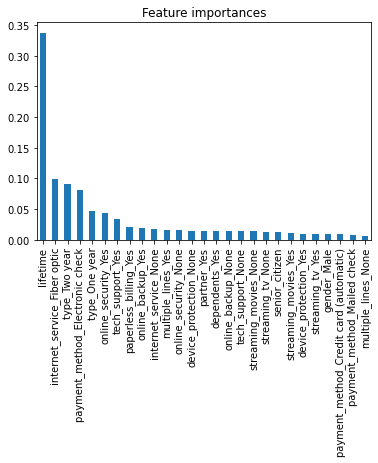

In [38]:
pd.Series(model_rfc.feature_importances_, index=features_train_ohe.columns).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature importances')

##### Случайный лес (alternative dataset)

In [39]:
model = RandomForestClassifier(random_state=42)
grid_param = {'n_estimators' : [50 * x for x in range(5, 11)],
              'max_depth' : [1 * x for x in range(8, 12)]}

grid_search = GridSearchCV(model, grid_param, scoring='roc_auc', n_jobs=-1, cv=3)
grid_search.fit(alt_features_train_ohe, alt_target_train_ohe)
grid_search.best_params_

{'max_depth': 8, 'n_estimators': 300}

In [40]:
start_time = timeit.default_timer()

model_rfc_alt = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=8)
model_rfc_alt.fit(alt_features_train_ohe, alt_target_train_ohe)

elapsed_time = timeit.default_timer() - start_time
results.loc['Случайный лес (alternative dataset)', 'Время обучения'] = elapsed_time

Text(0.5, 1.0, 'Feature importances')

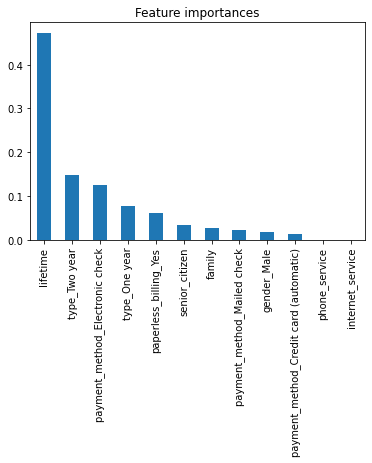

In [41]:
pd.Series(model_rfc_alt.feature_importances_, index=alt_features_train_ohe.columns).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature importances')

##### Catboost

In [42]:
model = CatBoostClassifier(random_state=42, verbose=0)
grid_param = {'iterations' : [50 * x for x in range(7, 11)],
              'depth' : [1 * x for x in range(1, 4)],
              'learning_rate' : [0.3, 0.5]}

grid_search = GridSearchCV(model, grid_param, scoring='roc_auc', n_jobs=-1, cv=3)
grid_search.fit(features_train_ohe, target_train_ohe)
grid_search.best_params_

{'depth': 2, 'iterations': 500, 'learning_rate': 0.5}

In [43]:
start_time = timeit.default_timer()

model_cbc = CatBoostClassifier(depth=2, iterations=500, learning_rate=0.5,
                               task_type='CPU', random_seed=42)
model_cbc.fit(features_train_ohe, target_train_ohe, verbose=40)

elapsed_time = timeit.default_timer() - start_time
results.loc['CatBoost', 'Время обучения'] = elapsed_time

0:	learn: 0.5142837	total: 3.37ms	remaining: 1.68s
40:	learn: 0.3325166	total: 145ms	remaining: 1.63s
80:	learn: 0.2861160	total: 283ms	remaining: 1.46s
120:	learn: 0.2650971	total: 419ms	remaining: 1.31s
160:	learn: 0.2433281	total: 571ms	remaining: 1.2s
200:	learn: 0.2312747	total: 713ms	remaining: 1.06s
240:	learn: 0.2165595	total: 852ms	remaining: 915ms
280:	learn: 0.2102838	total: 983ms	remaining: 766ms
320:	learn: 0.2053541	total: 1.13s	remaining: 631ms
360:	learn: 0.2016910	total: 1.28s	remaining: 492ms
400:	learn: 0.1987478	total: 1.42s	remaining: 351ms
440:	learn: 0.1960290	total: 1.57s	remaining: 210ms
480:	learn: 0.1938937	total: 1.7s	remaining: 67.3ms
499:	learn: 0.1932609	total: 1.77s	remaining: 0us


Text(0.5, 1.0, 'Feature importances')

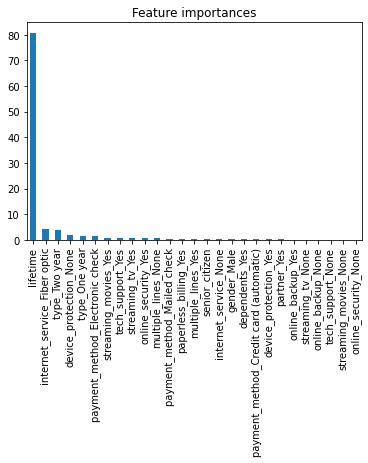

In [44]:
pd.Series(model_cbc.feature_importances_, index=features_train_ohe.columns).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature importances')

+ Важных признаков оказалось немного
+ Любопытно, что для разных моделей они несколько различаются

##### Catboost (alternative dataset)

In [45]:
model = CatBoostClassifier(random_state=42, verbose=0)
grid_param = {'iterations' : [50 * x for x in range(7, 11)],
              'depth' : [1 * x for x in range(1, 4)],
              'learning_rate' : [0.3, 0.5]}

grid_search = GridSearchCV(model, grid_param, scoring='roc_auc', n_jobs=-1, cv=3)
grid_search.fit(alt_features_train_ohe, alt_target_train_ohe)
grid_search.best_params_

{'depth': 2, 'iterations': 500, 'learning_rate': 0.5}

In [46]:
start_time = timeit.default_timer()

model_cbc_alt = CatBoostClassifier(depth=2, iterations=500, learning_rate=0.5,
                               task_type='CPU', random_seed=42)
model_cbc_alt.fit(alt_features_train_ohe, alt_target_train_ohe, verbose=40)

elapsed_time = timeit.default_timer() - start_time
results.loc['CatBoost (alternative dataset)', 'Время обучения'] = elapsed_time

0:	learn: 0.5469871	total: 2.94ms	remaining: 1.47s
40:	learn: 0.3487617	total: 123ms	remaining: 1.38s
80:	learn: 0.2992294	total: 249ms	remaining: 1.29s
120:	learn: 0.2687108	total: 352ms	remaining: 1.1s
160:	learn: 0.2506094	total: 454ms	remaining: 957ms
200:	learn: 0.2377130	total: 557ms	remaining: 829ms
240:	learn: 0.2296650	total: 655ms	remaining: 704ms
280:	learn: 0.2247960	total: 752ms	remaining: 586ms
320:	learn: 0.2212184	total: 845ms	remaining: 471ms
360:	learn: 0.2184552	total: 946ms	remaining: 364ms
400:	learn: 0.2162576	total: 1.05s	remaining: 261ms
440:	learn: 0.2140408	total: 1.15s	remaining: 154ms
480:	learn: 0.2120890	total: 1.26s	remaining: 49.6ms
499:	learn: 0.2112802	total: 1.31s	remaining: 0us


Text(0.5, 1.0, 'Feature importances')

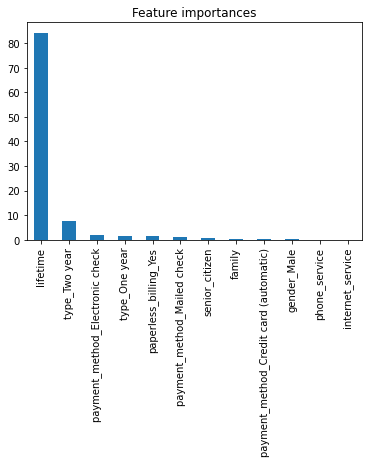

In [47]:
pd.Series(model_cbc_alt.feature_importances_, index=alt_features_train_ohe.columns).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature importances')

# 4. Тестирование моделей

##### Логистическая регрессия

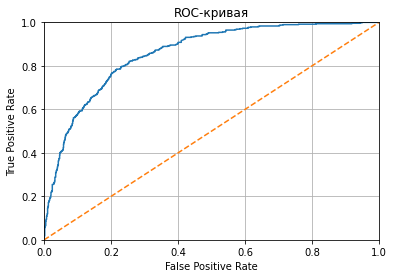

Accuracy = 0.813
Precision = 0.687
Recall = 0.572
F1-мера = 0.624
AUC-ROC = 0.858


In [48]:
auc_roc, accuracy = print_metrics(model_lr, features_test_ohe, target_test_ohe)
results.loc['Логистическая регрессия', 'AUC-ROC'] = auc_roc
results.loc['Логистическая регрессия', 'Accuracy'] = accuracy

##### Логистическая регрессия (alternative dataset)

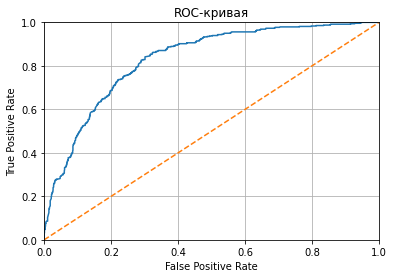

Accuracy = 0.784
Precision = 0.652
Recall = 0.443
F1-мера = 0.527
AUC-ROC = 0.831


In [49]:
auc_roc, accuracy = print_metrics(model_lr_alt, alt_features_test_ohe, alt_target_test_ohe)
results.loc['Логистическая регрессия (alternative dataset)', 'AUC-ROC'] = auc_roc
results.loc['Логистическая регрессия (alternative dataset)', 'Accuracy'] = accuracy

##### Случайный лес

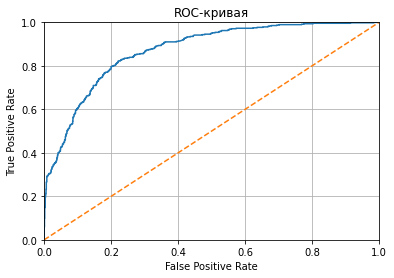

Accuracy = 0.813
Precision = 0.734
Recall = 0.489
F1-мера = 0.586
AUC-ROC = 0.871


In [50]:
auc_roc, accuracy = print_metrics(model_rfc, features_test_ohe, target_test_ohe)
results.loc['Случайный лес', 'AUC-ROC'] = auc_roc
results.loc['Случайный лес', 'Accuracy'] = accuracy

##### Случайный лес (alternative dataset)

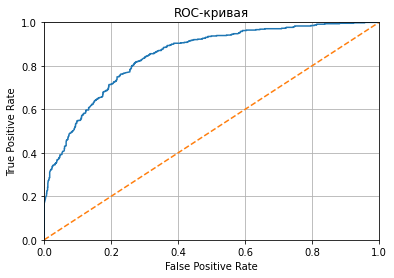

Accuracy = 0.804
Precision = 0.719
Recall = 0.459
F1-мера = 0.561
AUC-ROC = 0.848


In [51]:
auc_roc, accuracy = print_metrics(model_rfc_alt, alt_features_test_ohe, alt_target_test_ohe)
results.loc['Случайный лес (alternative dataset)', 'AUC-ROC'] = auc_roc
results.loc['Случайный лес (alternative dataset)', 'Accuracy'] = accuracy

##### Catboost

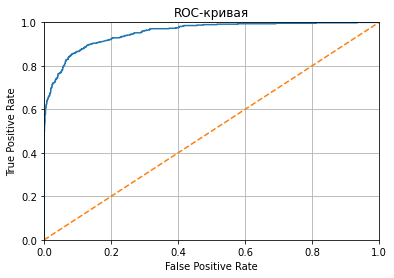

Accuracy = 0.904
Precision = 0.891
Recall = 0.737
F1-мера = 0.807
AUC-ROC = 0.954


In [52]:
auc_roc, accuracy = print_metrics(model_cbc, features_test_ohe, target_test_ohe)
results.loc['CatBoost', 'AUC-ROC'] = auc_roc
results.loc['CatBoost', 'Accuracy'] = accuracy

##### Catboost (alternative dataset)

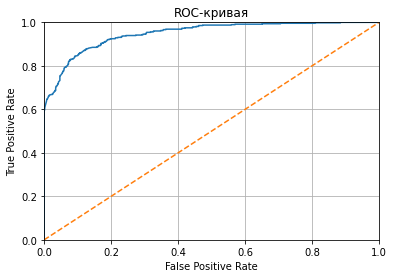

Accuracy = 0.894
Precision = 0.880
Recall = 0.706
F1-мера = 0.783
AUC-ROC = 0.949


In [53]:
auc_roc, accuracy = print_metrics(model_cbc_alt, alt_features_test_ohe, alt_target_test_ohe)
results.loc['CatBoost (alternative dataset)', 'AUC-ROC'] = auc_roc
results.loc['CatBoost (alternative dataset)', 'Accuracy'] = accuracy

# Итоги

In [54]:
results.sort_values(by='AUC-ROC', ascending=False)

,AUC-ROC,Accuracy,Время обучения
CatBoost,0.954026,0.904032,1.85393
CatBoost (alternative dataset),0.948761,0.89381,1.37363
Случайный лес,0.87141,0.812606,1.2583
Логистическая регрессия,0.857708,0.812606,0.0944713
Случайный лес (alternative dataset),0.84789,0.804089,0.666083
Логистическая регрессия (alternative dataset),0.831038,0.784214,0.0616794


+ С предсказанием лучше всего справился CatBoost
+ Использование альтернативно подготовленного датасета привело к ухудшению метрик
+ Ушедшие клиенты в среднем ежемесячно платили большие суммы
+ Риск ухода клиента выше всего в первые три месяца обслуживания
+ 94% ушедших клиентов пользовались интернетом, причём оптоволоконным интернетом пользовалось 

# Дополнительные комментарии

+ В целевом признаке явный дисбаланс классов, однако использование взвешивания классов не улучшало, либо ухудшало результат.
+ Если добавить признак *monthly_charges*, то результаты моделей ухудшатся.
+ Если в CatBoost загрузить категориальныйе признаки без предобработки OHE, то модель будет дольше обучаться и покажет менее хороший результат
+ Масштабирование численных признаков не приводило к улучшению результата.